In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!pip install transformers

In [30]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [0]:
import keras.backend as K
import tensorflow as tf

from scipy.spatial.distance import jensenshannon
from numpy import asarray

kl_div = tf.keras.losses.KLDivergence()
 
# calculate the js divergence
def js_divergence(p, q):
	m = 0.5 * (p + q)
	return 0.5 * kl_div(p, m) + 0.5 * kl_div(q, m)

def js_distance(y_true, y_pred):
  return K.sqrt(js_divergence(y_true, y_pred))


In [0]:
from transformers import DistilBertPreTrainedModel, DistilBertModel
import torch.nn as nn
from transformers import BertTokenizer, DistilBertTokenizer


class MyDistilBertForSequenceClassificationReact(DistilBertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.distilbert = DistilBertModel(config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.classifier = nn.Linear(config.dim, 5)
        # self.classifier = nn.Linear(config.dim, config.num_labels)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, head_mask=None, inputs_embeds=None, labels=None):
        
        distilbert_output = self.distilbert(
            input_ids=input_ids, attention_mask=attention_mask, head_mask=head_mask, inputs_embeds=inputs_embeds
        )
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits = self.classifier(pooled_output)  # (bs, dim)
        # new addition jordan
        logits = nn.ReLU()(logits)
        outputs = (logits,) + distilbert_output[1:]
        if labels is not None:
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(logits.view(-1, 5), labels.view(-1, 5))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

class MyDistilBertForSequenceClassificationExpress(DistilBertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.distilbert = DistilBertModel(config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.classifier = nn.Linear(config.dim, 3)
        # self.classifier = nn.Linear(config.dim, config.num_labels)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, head_mask=None, inputs_embeds=None, labels=None):
        
        distilbert_output = self.distilbert(
            input_ids=input_ids, attention_mask=attention_mask, head_mask=head_mask, inputs_embeds=inputs_embeds
        )
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits = self.classifier(pooled_output)  # (bs, dim)
        # new addition jordan
        logits = nn.ReLU()(logits)
        outputs = (logits,) + distilbert_output[1:]
        if labels is not None:
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(logits.view(-1, 3), labels.view(-1, 3))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)



In [0]:
import pandas as pd
import numpy as np

# Load the dataset into a pandas dataframe.
sentences_holdout = np.load("./drive/My Drive/Colab Notebooks/MainModels/sentences_holdout.npy",allow_pickle=True)
labels_holdout = np.load("./drive/My Drive/Colab Notebooks/MainModels/labels_holdout.npy",allow_pickle=True)

In [34]:
print(sentences_holdout.shape)
print(labels_holdout.shape)

(8,)
(8, 5)


Load express base model

In [0]:
# Load a trained model and vocabulary that you have fine-tuned
output_dir = "./drive/My Drive/Colab Notebooks/MainModels/express_base_model"
model = MyDistilBertForSequenceClassificationExpress.from_pretrained(
    output_dir, # Use the 12-layer BERT model, with an uncased vocab.
    # num_labels = 5, # The number of output labels--2 for binary classification.
    num_labels = 1, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
model.cuda()
tokenizer = DistilBertTokenizer.from_pretrained(output_dir,do_lower_case=True)


Express base model predictions

In [36]:
import pandas as pd
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

max_len = 36

input_ids = []
attention_masks = []

for sent in sentences_holdout:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                  )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
batch_size = 32
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
# Put model in evaluation mode
model.eval()
# Tracking variables 
express_predictions = []
# Predict 
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask = batch
  
  with torch.no_grad():
      outputs = model(b_input_ids, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  express_predictions.append(logits)

Predicting labels for 8 test sentences...


In [37]:
print(len(express_predictions))
print(express_predictions[0])

1
[[3.3496933 3.1076722 3.183127 ]
 [2.9912043 3.0952132 3.1892734]
 [3.0656917 3.0530887 3.1847665]
 [2.9583404 3.112419  3.1115248]
 [2.942217  3.089937  3.1131277]
 [3.3888288 3.5354095 3.3147266]
 [3.2598684 3.0601778 3.1180634]
 [2.9415276 3.0026827 3.0562735]]


In [0]:
np.save('./express_predictions.npy', express_predictions,allow_pickle=True)


Load react base model


In [0]:
# Load a trained model and vocabulary that you have fine-tuned
output_dir = "./drive/My Drive/Colab Notebooks/MainModels/react_base_model"
model = MyDistilBertForSequenceClassificationReact.from_pretrained(
    output_dir, # Use the 12-layer BERT model, with an uncased vocab.
    # num_labels = 5, # The number of output labels--2 for binary classification.
    num_labels = 1, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
model.cuda()
tokenizer = DistilBertTokenizer.from_pretrained(output_dir,do_lower_case=True)


React base model predictions

In [40]:
import pandas as pd
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

max_len = 36

input_ids = []
attention_masks = []

for sent in sentences_holdout:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                  )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
batch_size = 32
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
# Put model in evaluation mode
model.eval()
# Tracking variables 
react_predictions = []
# Predict 
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask = batch
  
  with torch.no_grad():
      outputs = model(b_input_ids, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  react_predictions.append(logits)

Predicting labels for 8 test sentences...


Combine

In [41]:
react_predictions = np.vstack(react_predictions)
express_predictions = np.vstack(express_predictions)
print(react_predictions.shape)
print(express_predictions.shape)
data = np.concatenate((react_predictions, express_predictions),axis=1)
print(data.shape)
labels = labels_holdout

(8, 5)
(8, 3)
(8, 8)


Create Meta Learner

In [68]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D, MaxPooling1D, Flatten, Embedding, Dropout
from keras.utils import plot_model

metrics = ['mean_squared_error', 'mean_absolute_error', js_distance]

# def create_model():
#   model = Sequential()
#   model.add(Dense(units=300, activation='relu'))
#   model.add(Dense(units=5, activation='relu'))

#   model.compile(loss='mean_squared_error', optimizer='adam', metrics=metrics)

#   return model
layers = 3
units = 64
dropout_rate = 0.2
def create_model():
  model = Sequential()
  # model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

  for _ in range(layers-1):
      model.add(Dense(units=units, activation='relu'))
      model.add(Dropout(rate=dropout_rate))
  model.add(Dense(units=5, activation='relu'))
  

  # model.compile(loss='mean_squared_error', optimizer='adam', metrics=metrics)
  print(model.summary())
  from keras.utils.vis_utils import plot_model
  plot_model(model, to_file='ensemble.png', show_shapes=True, show_layer_names=True)
  return model

create_model()


ValueError: ignored

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_62 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_38 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 5)                 325       
Total params: 9,221
Trainable params: 9,221
Non-trainable params: 0
___________________________________________________

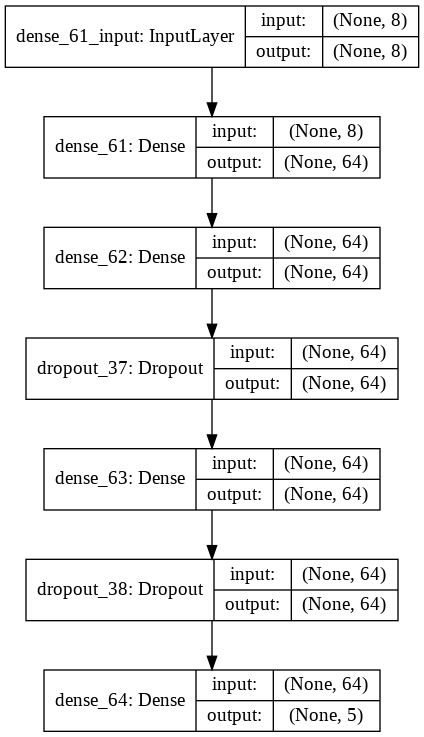

In [76]:
from keras.layers import Dense
layers = 3
units = 64
dropout_rate = 0.2

model = Sequential()
# model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

model.add(Dense(units, input_dim=8, activation='relu'))

for _ in range(layers-1):
    model.add(Dense(units=units, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=5, activation='relu'))


# model = model.compile(loss='mean_squared_error', optimizer='adam', metrics=metrics)
print(model.summary())
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='ensemble.png', show_shapes=True, show_layer_names=True)

Train eval func

In [43]:
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split


def train_and_evaluate_model(model, data_train, labels_train, data_test, labels_test):
  print("Training:")
  # data_train, data_val, labels_train, labels_val = train_test_split(data_train, labels_train, test_size=0.2, shuffle=True)
  data_test, data_val, labels_test, labels_val = train_test_split(data_test, labels_test, test_size=0.5, shuffle=False)

  model.fit(data_train, labels_train, 
        epochs=20, batch_size=128, verbose=1, shuffle=False,
        validation_data=(data_val, labels_val))
  
  print("Evaluating:")
  scores = model.evaluate(data_test, labels_test, verbose=1)
  print("Final scores for fold:")
  print(model.metrics_names, scores) 
  return scores

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


RUn evals

In [0]:
useHoldout = True

min_reacts = 1
# if (len(data) > 10000):
#   useHoldout = True

K fold

In [45]:
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import normalize


# if not False:
#   print("KFOLD")  
#   n_folds = 5
#   kf = KFold(n_folds, shuffle=False)
#   i = 0

#   # Define per-fold score containers
#   scores_per_fold = []

#   for train_index, test_index in kf.split(data):
#     print("Running Fold", i+1, "/", n_folds)
#     data_train, data_test = data[train_index], data[test_index]
#     labels_train, labels_test = labels[train_index], labels[test_index]
    
#     model = None # Clearing the NN.
#     model = create_model()

#     # scores = train_and_evaluate_model(model, data_train, labels_train, data_test, labels_test)
#     # scores_per_fold.append(scores)

#     i += 1

  

KFOLD
Running Fold 1 / 5


ValueError: ignored

In [0]:
if not useHoldout:

  print('Average scores across all folds:')
  for metric_index, metric_name in enumerate(metrics):
    metric_total = 0
    for scores in scores_per_fold:
      metric_total += scores[metric_index + 1]
    print(metric_name, metric_total/n_folds )
  print(scores_per_fold)
  

Holdout

In [46]:
from sklearn.model_selection import train_test_split

if useHoldout:
  print("HOLDOUT")

  data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2, shuffle=False)

  model = None # Clearing the NN.
  model = create_model()

  # scores = train_and_evaluate_model(model, data_train, labels_train, data_test, labels_test)
  # print(model.metrics_names, scores) 

HOLDOUT


ValueError: ignored

In [58]:
from keras.models import load_model


# !cd "./drive/My Drive/Colab Notebooks/MainModels"
# ! ls
load_model("./drive/My Drive/Colab Notebooks/MainModels/ensemble_meta_learner.h5")



ValueError: ignored

Just react

In [0]:
import sklearn
print(data_test.shape)
data_test = data_test[:,:5]

mse = sklearn.metrics.mean_squared_error(labels_test, data_test)
print(data_test[0])
print(labels_test [0])
print(mse)
print(sklearn.metrics.mean_absolute_error(labels_test, data_test))
print(js_distance(labels_test,data_test))

print(scores[0] < mse)

Manual test

In [0]:
# # data, labels = load_data()
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# t = Tokenizer()

# example_data = ['fuck you', 'i love you']
# print(example_data)
# encoded_example_data = t.texts_to_sequences(example_data)
# padded_example_data = pad_sequences(encoded_example_data, maxlen=max_len, padding='post')
# example_data = padded_example_data
# print(model.predict(example_data, verbose=0))
